In [35]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box
import random
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

In [36]:
with open('sample.geojson', 'r', encoding='windows-1251') as f:
    data = json.load(f)

print(json.dumps(data, ensure_ascii=False, indent=4))

{
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            39.787879,
                            57.44876
                        ],
                        [
                            39.789041,
                            57.448078
                        ],
                        [
                            39.794747,
                            57.450329
                        ],
                        [
                            39.791648,
                            57.450982
                        ],
                        [
                            39.787879,
                            57.44876
                        ]
                    ]
                ]
            },
            "properties": {
                "name": "Зона застройки"
            }
     

In [37]:
def Create_gdf(data:dict):

    '''Функция получает на вход данные в формате dict и возвращает геодатасет с размеченными областями'''

    geometries = []
    names = []
    restrictions = []

    for feature in data['features']: # Итерируем по фичам
        geom_type = feature['geometry']['type'] # Тип области
        restriction = feature['properties'].get('restriction', None) # Получаем ограничение на область. Если ограничений нет - None

        if geom_type == 'Polygon': # Для полигонов
            coords = feature['geometry']['coordinates'][0] # Получаем координаты
            polygon = Polygon([(lon, lat) for lon, lat in coords]) # Создаем полигон шейпли по координатам
            geometries.append(polygon) # Тут и ниже - собираем строку для gdf
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
        elif geom_type == 'LineString': # Аналогично для линий
            coords = feature['geometry']['coordinates']
            line = LineString([(lon, lat) for lon, lat in coords])
            geometries.append(line)
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
    res = gpd.GeoDataFrame({'geometry' : geometries, 'name' : names, 'restrictions' : restrictions})

    return res

In [38]:
gdf = Create_gdf(data)
gdf

,geometry,name,restrictions
0,"POLYGON ((39.78788 57.44876, 39.78904 57.44808...",Зона застройки,None
1,"POLYGON ((39.78759 57.45067, 39.78954 57.44924...",Лесная зона,building not allowed
2,"POLYGON ((39.78659 57.44999, 39.78977 57.44868...",Водоем,building not allowed
3,"LINESTRING (39.78752 57.45061, 39.79018 57.450...",Дорога,building not allowed


In [39]:
def Plot_empty(gdf:gpd.GeoDataFrame, width:int=20, height:int=40):

    '''Функция получает на вход датасет в формате GeoDataFrame и отрисовывает зоны, хранящиеся в нем.
    Обязательные полня в датасете:
    geometry - зоны в формате geometry
    name - названия зон
    restrictions - ограничения на строительства
    На выходе строит карту полученных зон'''

    fig, ax = plt.subplots(figsize=(width, height))

    # Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
    forest_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Лесная зона')]
    water_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Водоем')]
    building_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].isnull())]
    roads = gdf[gdf['geometry'].type == 'LineString']

    # Плотим зомы
    forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
    water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
    roads.plot(ax=ax, color='black', linewidth=4, legend=False)
    building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)

    # Задаем легенду
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
        plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги')
    ]

    ax.legend(handles=handles)
    ax.set_title('План зон')
    ax.set_xlabel('Долгота')
    ax.set_ylabel('Широта')
    plt.grid()
    plt.show()

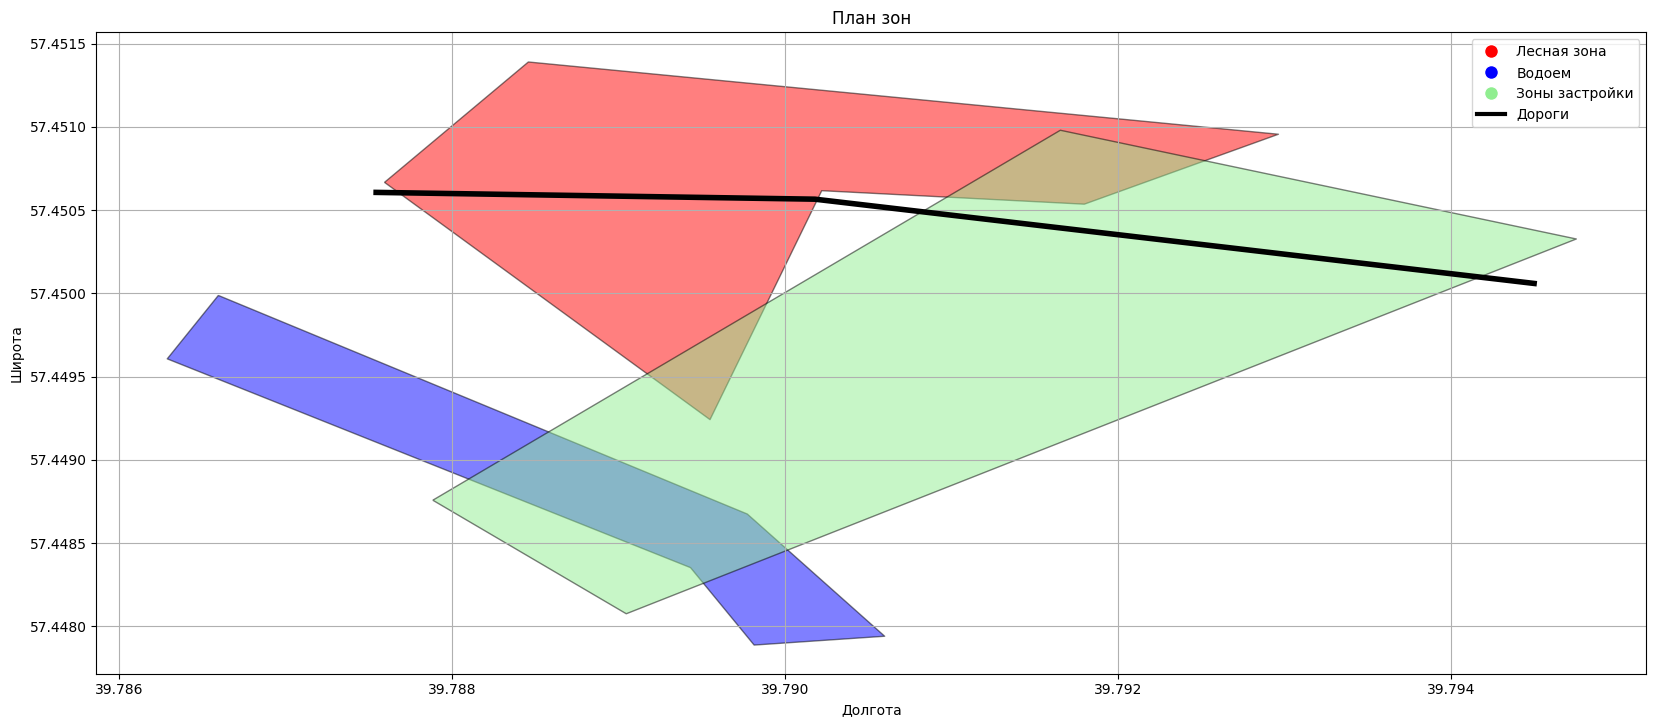

In [40]:
Plot_empty(gdf)

In [41]:
allowed_percent = 0.50
total_area = gdf[gdf['name'] == 'Зона застройки']['geometry'][0]
restricted_zones = gdf[gdf['name'] != 'Зона застройки']['geometry']
combined_restricted_zones = restricted_zones.unary_union
allowed_area = total_area.difference(combined_restricted_zones).area

C:\Users\Asus\AppData\Local\Temp\ipykernel_2504\24405676.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_restricted_zones = restricted_zones.unary_union


In [ ]:
polygon = Polygon(polygon_coords)

# Проверка площади полигона
print(f"Area of the polygon: {polygon.area}")

def add_streets_within_polygon(polygon, num_streets_x=4, num_streets_y=3):
    # Получаем границы полигона
    min_x, min_y, max_x, max_y = polygon.bounds

    # Начальный и конечный координаты для улиц
    streets = []

    # Добавляем вертикальные улицы
    for i in range(num_streets_x):
        # Генерируем значение x в пределах границ
        x = min_x + (max_x - min_x) * (i + 1) / (num_streets_x + 1)
        # Начальные и конечные точки для вертикальной улицы
        street = LineString([(x, min_y), (x, max_y)])
        # Обрезаем линию до границ полигона
        street_within_polygon = street.intersection(polygon)
        # Проверяем, есть ли полученная линия и добавляем
        if street_within_polygon.is_empty:
            continue
        streets.append(street_within_polygon)

    # Добавляем горизонтальные улицы
    for i in range(num_streets_y):
        # Генерируем значение y в пределах границ
        y = min_y + (max_y - min_y) * (i + 1) / (num_streets_y + 1)
        # Начальные и конечные точки для горизонтальной улицы
        street = LineString([(min_x, y), (max_x, y)])
        # Обрезаем линию до границ полигона
        street_within_polygon = street.intersection(polygon)
        if street_within_polygon.is_empty:
            continue
        streets.append(street_within_polygon)

    return streets

In [42]:
# Функция для размещения парков
def place_park(polygon, park_size, restricted_zones, placed_parks):
    attempts = 0
    max_attempts = 1000  # Ограничение на количество попыток

    minx, miny, maxx, maxy = polygon.bounds

    while attempts < max_attempts:
        x = random.uniform(minx, maxx - park_size)
        y = random.uniform(miny, maxy - park_size)

        park = box(x, y, x + park_size, y + park_size)

        if (
            polygon.contains(park) and 
            not restricted_zones.intersects(park) and 
            all(park.distance(placed_park) >= 0.0005 for placed_park in placed_parks)  
        ):
            return park
        
        attempts += 1

    print("Нет места для размещения парков")
    return None

In [43]:
def place_house(polygon, square_size, restricted_zones, placed_squares):
    attempts = 0  # Счетчик попыток
    max_attempts = 1000  # Ограничение на количество попыток

    # Определяем границы полигона
    minx, miny, maxx, maxy = polygon.bounds

    while attempts < max_attempts:
        # Генерируем случайные координаты внутри зоны застройки
        x = random.uniform(minx, maxx - square_size) 
        y = random.uniform(miny, maxy - square_size)

        square = box(x, y, x + square_size, y + square_size)

        # Проверяем условия
        if (
            polygon.contains(square) and 
            not restricted_zones.intersects(square) and 
            all(square.distance(placed_square) >= 0.0001 for placed_square in placed_squares)  # Проверяем минимальное расстояние
        ):
            return square
        
        attempts += 1  # Увеличиваем счетчик попыток

    print("Нет места для размещения домов")
    return None

In [44]:
allowed_percent = 0.50
total_area = gdf[gdf['name'] == 'Зона застройки']['geometry'][0]
restricted_zones = gdf[gdf['name'] != 'Зона застройки']['geometry']
combined_restricted_zones = restricted_zones.unary_union
allowed_area = total_area.difference(combined_restricted_zones).area

# Параметры для парков
park_size = 0.0005  # Размер стороны парка в метрах
parks = []
placed_parks = []

# Параметры для домов
square_size = 0.0001  # размер стороны квадрата в метрах
squares = []
used_area = 0
placed_squares = []

# Печатаем начальные условия
print(f"Допустимая площадь: {allowed_area}\nВся площадь: {total_area.area}")

# Размещение двух парков
for _ in range(10):
    park = place_park(total_area, park_size, combined_restricted_zones, placed_parks)
    if park:
        parks.append(park)
        placed_parks.append(park)
        
# Обновляем restricted_zones с зонами парков
if parks:
    combined_park_zones = gpd.GeoSeries(parks).unary_union
    combined_restricted_zones = combined_restricted_zones.union(combined_park_zones)

# Размещение домов
while used_area < allowed_area * allowed_percent:
    square = place_house(total_area, square_size, combined_restricted_zones, placed_squares)
    
    if square:  
        squares.append(square)
        placed_squares.append(square)
        used_area += square.area
    else:
        break 


# Расчет процентов и финальная проверка
percentage_used = (used_area / allowed_area) * 100
print(f"Застроено домов: {percentage_used:.2f}% от доступной площади.")

# Создаем GeoDataFrame для размещенных домов
squares_gdf = gpd.GeoDataFrame(geometry=squares, crs=gdf.crs)
squares_gdf['name'] = 'Дом'
squares_gdf['restrictions'] = None

# Создаем GeoDataFrame для размещенных парков
parks_gdf = gpd.GeoDataFrame(geometry=parks, crs=gdf.crs)
parks_gdf['name'] = 'Парк'
parks_gdf['restrictions'] = None

# Объединяем со старым GeoDataFrame
final_gdf = pd.concat([gdf, squares_gdf, parks_gdf], ignore_index=True)

# Сохранение в GeoJSON
final_gdf.to_file("site_plan.geojson", driver='GeoJSON')

# Для подтверждения, можно вывести результат
print(f'{final_gdf}\nЗанятая площадь: {used_area}\nДоступная площадь: {allowed_area}')
percentage_used = (used_area / allowed_area) * 100
print(f"Застроено домов: {percentage_used:.2f}% от доступной площади.")


C:\Users\Asus\AppData\Local\Temp\ipykernel_2504\2818967074.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_restricted_zones = restricted_zones.unary_union


Допустимая площадь: 6.688176192099185e-06
Вся площадь: 7.927144500001154e-06
Нет места для размещения парков
Нет места для размещения парков
Нет места для размещения парков
Нет места для размещения парков
Нет места для размещения парков
Нет места для размещения парков
Нет места для размещения парков


C:\Users\Asus\AppData\Local\Temp\ipykernel_2504\2818967074.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_park_zones = gpd.GeoSeries(parks).unary_union


Нет места для размещения домов
Застроено домов: 12.11% от доступной площади.
                                             geometry            name  \
0   POLYGON ((39.78788 57.44876, 39.78904 57.44808...  Зона застройки   
1   POLYGON ((39.78759 57.45067, 39.78954 57.44924...     Лесная зона   
2   POLYGON ((39.78659 57.44999, 39.78977 57.44868...          Водоем   
3   LINESTRING (39.78752 57.45061, 39.79018 57.450...          Дорога   
4   POLYGON ((39.78977 57.44895, 39.78977 57.44905...             Дом   
..                                                ...             ...   
83  POLYGON ((39.79282 57.45029, 39.79282 57.45039...             Дом   
84  POLYGON ((39.79097 57.44989, 39.79097 57.44999...             Дом   
85  POLYGON ((39.79085 57.44933, 39.79085 57.44983...            Парк   
86  POLYGON ((39.79203 57.44934, 39.79203 57.44984...            Парк   
87  POLYGON ((39.79309 57.44971, 39.79309 57.45021...            Парк   

            restrictions  
0                  

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [51]:
final_gdf.head(10)

,geometry,name,restrictions
0,"POLYGON ((39.78788 57.44876, 39.78904 57.44808...",Зона застройки,None
1,"POLYGON ((39.78759 57.45067, 39.78954 57.44924...",Лесная зона,building not allowed
2,"POLYGON ((39.78659 57.44999, 39.78977 57.44868...",Водоем,building not allowed
3,"LINESTRING (39.78752 57.45061, 39.79018 57.450...",Дорога,building not allowed
4,"POLYGON ((39.78977 57.44895, 39.78977 57.44905...",Дом,None
5,"POLYGON ((39.78901 57.44822, 39.78901 57.44832...",Дом,None
6,"POLYGON ((39.78956 57.44894, 39.78956 57.44904...",Дом,None
7,"POLYGON ((39.79357 57.44998, 39.79357 57.45008...",Дом,None
8,"POLYGON ((39.79166 57.45019, 39.79166 57.45029...",Дом,None
9,"POLYGON ((39.79142 57.44989, 39.79142 57.44999...",Дом,None


In [45]:
# # Параметры квадрата
# square_size = 0.0001  # размер стороны квадрата в метрах

# squares = []
# used_area = 0
# placed_squares = []

# # Печатаем начальные условия
# print(f"Допустимая площадь: {allowed_area}\nВся площадь: {total_area.area}")

# while used_area < allowed_area * allowed_percent:
#     square = place_house(total_area, square_size, restricted_zones, placed_squares)
    
#     if square:  # Проверьте, создан ли квадрат
#         squares.append(square)
#         placed_squares.append(square)
#         used_area += square.area
#     else:
#         break 

# # Расчет процентов и финальная проверка
# percentage_used = (used_area / allowed_area) * 100
# print(f"Застроено {percentage_used:.2f}% от доступной площади.")

# squares_gdf = gpd.GeoDataFrame(geometry=squares, crs=gdf.crs)
# squares_gdf['name'] = 'Дом'
# squares_gdf['restrictions'] = None  # В случае, если для домов нет ограничений

# # Объединяем со старым GeoDataFrame
# final_gdf = pd.concat([gdf, squares_gdf], ignore_index=True)

# # Для подтверждения, можно вывести результат
# print(f'{final_gdf}\nЗанятая площадь: {used_area}\nДоступная площадь: {allowed_area}')
# percentage_used = (used_area / allowed_area) * 100
# print(f"Застроено {percentage_used:.2f}% от доступной площади.")

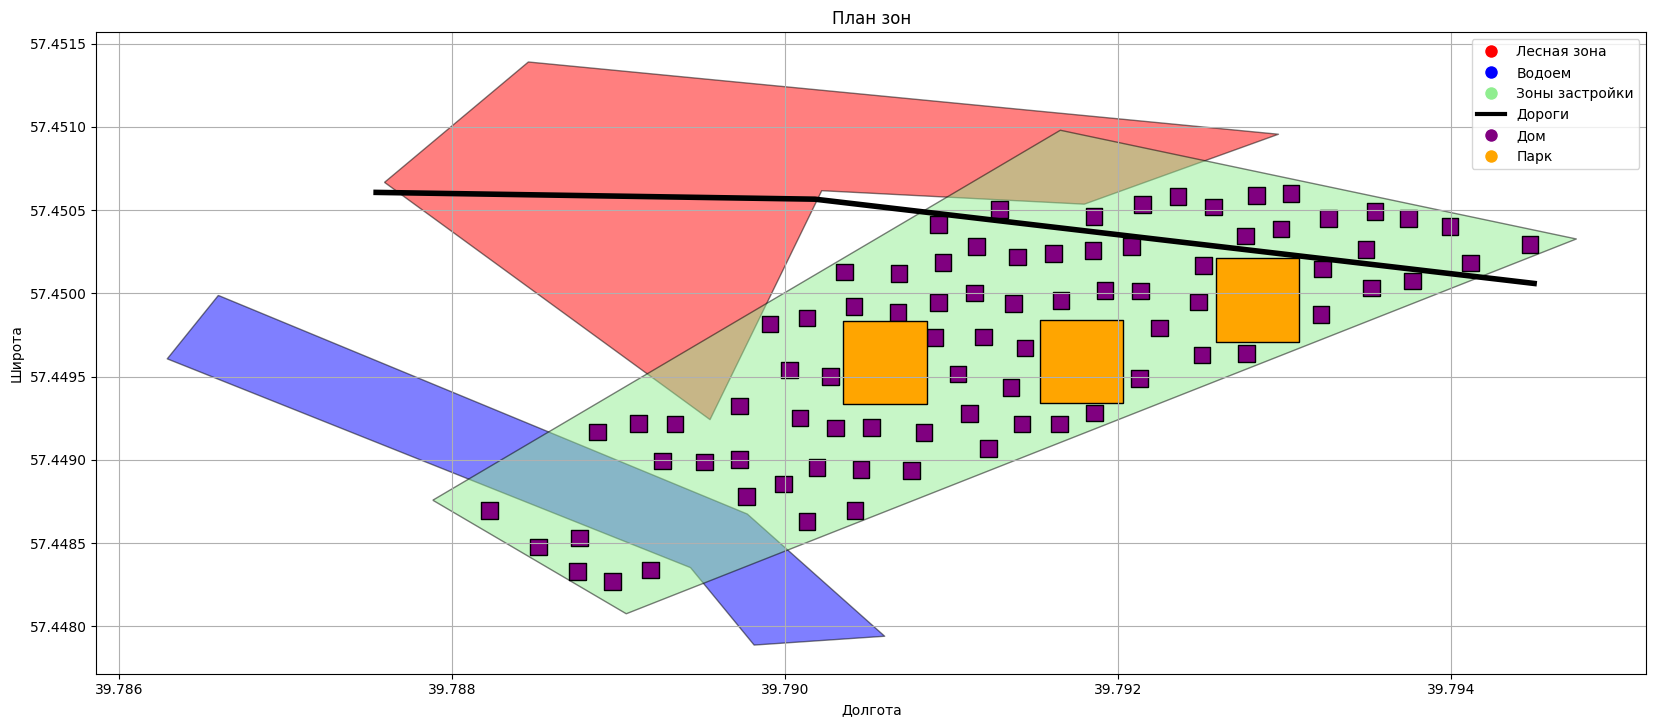

In [46]:
fig, ax = plt.subplots(figsize=(20, 40))

# Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
forest_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Лесная зона')]
water_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Водоем')]
building_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Зона застройки')]
roads = final_gdf[final_gdf['geometry'].type == 'LineString']
houses = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Дом')]
parks = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Парк')]

# Плотим зомы
forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
roads.plot(ax=ax, color='black', linewidth=4, legend=False)
building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)
houses.plot(ax=ax, color='purple', edgecolor='black', legend=False)
parks.plot(ax=ax, color='orange', edgecolor='black', legend=False)

# Задаем легенду
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги'),
    plt.Line2D([0], [0], marker='o', color='w', label='Дом', markerfacecolor='purple', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Парк', markerfacecolor='orange', markersize=10)
]

ax.legend(handles=handles)
ax.set_title('План зон')
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
plt.grid()
plt.show()

In [47]:
# import random
# from shapely.geometry import LineString, Point, Polygon
# import geopandas as gpd

# def place_broken_line(polygon, num_points=5):
#     # Список контрольных точек
#     control_points = []
    
#     # Получаем границы полигона
#     minx, miny, maxx, maxy = polygon.bounds

#     while len(control_points) < num_points:
#         # Генерируем случайные координаты внутри границ полигона
#         x = random.uniform(minx, maxx)
#         y = random.uniform(miny, maxy)
#         point = Point(x, y)
        
#         # Проверяем, находится ли точка внутри полигона
#         if polygon.contains(point):
#             control_points.append(point)
    
#     # Сортируем контрольные точки по их x-координатам
#     control_points.sort(key=lambda p: p.x)
    
#     # Создаем линию из контрольных точек
#     broken_line = LineString([point for point in control_points])
    
#     return broken_line

# # Пример использования функции
# # Создайте тестовый полигон
# polygon = Polygon([(0, 0), (4, 0), (4, 4), (0, 4)])
# broken_line = place_broken_line(polygon, num_points=10)

# # Преобразуем в GeoDataFrame для визуализации (если необходимо)
# gdf = gpd.GeoDataFrame(geometry=[polygon, broken_line], crs="EPSG:4326")
# print(gdf)

# # Если нужно, визуализируйте результаты
# import matplotlib.pyplot as plt

# gdf.boundary.plot(color='black')
# plt.show()
